In [ ]:
import re
import csv
import numpy as np
import pandas as pd
import random
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [ ]:
embedding_dim = 100
max_length = 16
trunc_type = "post"
padding_type = "post"
training_size = 1600000
test_portion = 0.1
oov__tok = "<OOV>"

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datasets_encoding = "ISO-8859-1"
data = pd.read_csv('/content/drive/MyDrive/dataset/suicidalDataset.csv', encoding=datasets_encoding)

In [ ]:
data.tail()

,Unnamed: 0,tweet,class,intention
232040,232062,If you don't like rock then your not going to ...,non-suicide,0.0
232041,232063,You how you can tell i have so many friends an...,non-suicide,0.0
232042,232064,pee probably tastes like salty teaðð¦â¼ï...,non-suicide,0.0
232043,232065,The usual stuff you find hereI'm not posting t...,suicide,1.0
232044,232066,I still haven't beaten the first boss in Hollo...,non-suicide,0.0


In [ ]:
data.shape

(232045, 4)

In [ ]:
data.head()

,Unnamed: 0,tweet,class,intention
0,0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1.0
1,1,Am I weird I don't get affected by compliments...,non-suicide,0.0
2,2,Finally 2020 is almost over... So I can never ...,non-suicide,0.0
3,3,i need helpjust help me im crying so hard,suicide,1.0
4,4,"Iâm so lostHello, my name is Adam (16) and I...",suicide,1.0


In [ ]:
data.describe()

,Unnamed: 0,intention
count,232045.000000,232045.000000
mean,116035.314366,0.500041
std,66992.308570,0.500001
min,0.000000,0.000000
25%,58019.000000,0.000000
50%,116036.000000,1.000000
75%,174051.000000,1.000000
max,232066.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232045 entries, 0 to 232044
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  232045 non-null  int64  
 1   tweet       232045 non-null  object 
 2   class       232045 non-null  object 
 3   intention   232045 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 7.1+ MB


In [ ]:
data.columns

Index(['Unnamed: 0', 'tweet', 'class', 'intention'], dtype='object')

In [ ]:
data = data[["tweet", "intention"]]

In [ ]:
data.columns

Index(['tweet', 'intention'], dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232045 entries, 0 to 232044
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   tweet      232045 non-null  object 
 1   intention  232045 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.5+ MB


In [ ]:
data["intention"].value_counts()

1.0    116032
0.0    116013
Name: intention, dtype: int64

<Figure size 576x432 with 0 Axes>

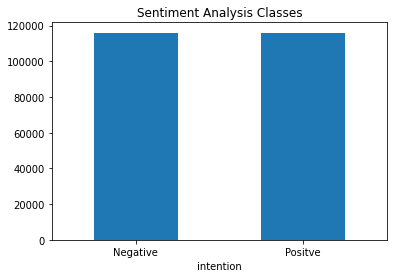

In [ ]:
plt.figure(figsize = (8, 6))
ax = data.groupby('intention').count().plot(kind = 'bar',
                                               title = "Sentiment Analysis Classes", 
                                               legend = False)
ax.set_xticklabels(["Negative", "Positve"], rotation = 0)
plt.show()

In [ ]:
tweet, intention = list(data['tweet']), list(data['intention'])

In [ ]:
tweet[5555]

"Gf is laying next to me, screaming she wants to die, I'm scared and holding onto herGf lost her job today. I have been wrestling with her for the past hour. We are both tired. She's laying on her side, still feeling it. I'm scared and worried but trying to focus on her and her needs right now. \n\nSuicide prevention line has already been called, they will check back in at 7. \n\nShe won't talk to her family, not ready for that. \n\nMy mom is aware and will Calle back at 730. \n\nI will call the police if she gets away from or seriously hurts me or herself or gets a weapon.\n\n\n I'm trying\n\n\nI don't know what to do. And I'm scared. \n\n5 minutes at a time.\n\nGf is half asleep.  Scared and on reddit ... fuck\n\n\nEdit, 1024pm pst, we are still here. Both exhausted, we had some dinner, I had more trouble keeping it down then she did, I laid down for a minute (even been able to go the bathroom and take out the trash and she hasn't been trying anything). Now we are both just laying do

In [ ]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
'@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
'<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
def data_preprocess(textdata):
    processedText = []
    word_Lem = WordNetLemmatizer()
    
    url_pattern = r"((http://)[^ ]*|(https://)^ ]*( www\.)[^ ]*)"
    user_pattern = '@[^\s]+'
    alpha_pattern = "[^a-zA-Z0-9]"
    sequence_pattern = r"(.)\1\1+"
    sequence_pattern_replace = "\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        tweet = re.sub(url_pattern, " URL", tweet)
        
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
            
        tweet = re.sub(user_pattern, "USER", tweet)
        tweet = re.sub(alpha_pattern, " ", tweet)
        tweet = re.sub(sequence_pattern, sequence_pattern_replace, tweet)
        
        
        tweetwords = ""
        for word in tweet.split():
            if len(word) > 1:
                word  = word_Lem.lemmatize(word)
                tweetwords += (word+ " ")
                
        processedText.append(tweetwords)
        
    return processedText

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import time
t = time.time()
processtext = data_preprocess(tweet)
print("Time taken for process: ", round(time.time() - t), "Seconds")

Time taken for process:  153 Seconds


In [ ]:
data_neg = processtext[:116032]
data_pos = processtext[116013:]

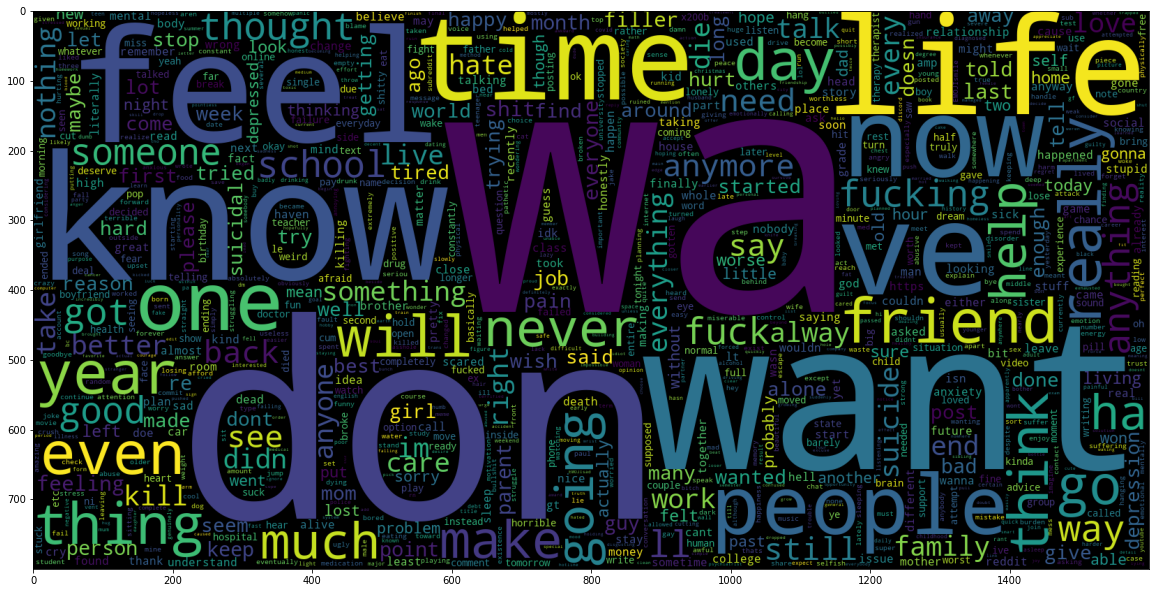

In [ ]:
plt.figure(figsize = (20, 18))
wc = WordCloud(max_words= 1000, width = 1600, height = 800,
              collocations = False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.show()

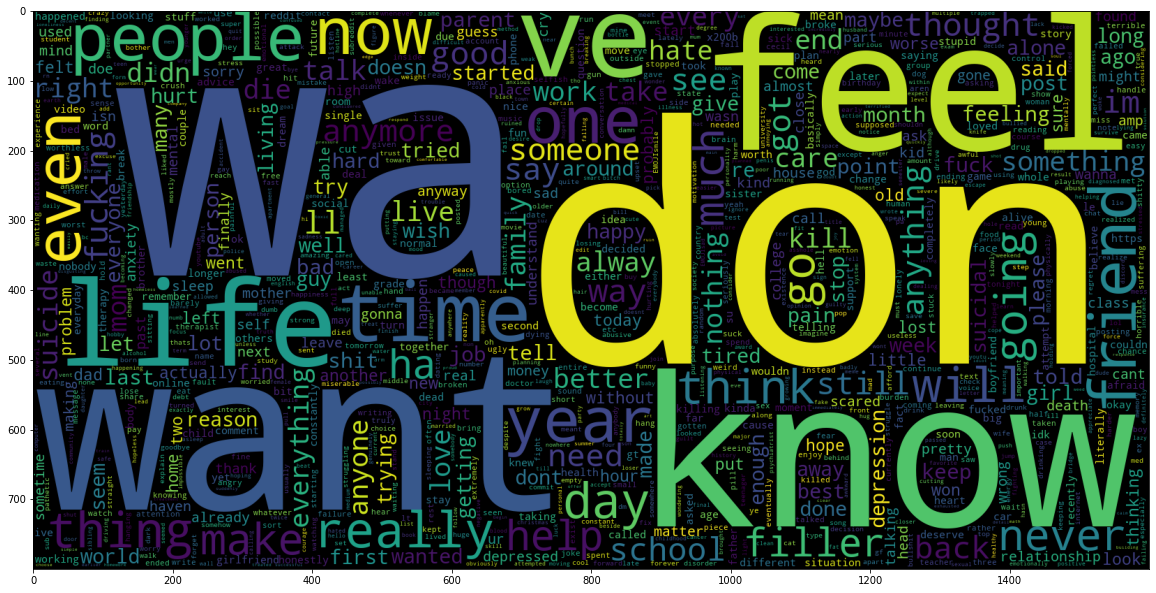

In [ ]:
plt.figure(figsize = (20, 18))
wc = WordCloud(max_words= 1000, width = 1600, height = 800,
              collocations = False).generate(" ".join(data_pos))
plt.imshow(wc)
plt.show()

In [ ]:
data.head()

,tweet,intention
0,Ex Wife Threatening SuicideRecently I left my ...,1.0
1,Am I weird I don't get affected by compliments...,0.0
2,Finally 2020 is almost over... So I can never ...,0.0
3,i need helpjust help me im crying so hard,1.0
4,"Iâm so lostHello, my name is Adam (16) and I...",1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processtext,
                                                    intention,
                                                    test_size = 0.2, random_state = 0)

In [ ]:
X_test[1]

'just want to stop existing just tired of this routine you know just don want to exist anymore freakin\x01\x01 tire\x01\x01 don want to hurt my family make them pay attention to me or pity me or feel sad so instead of killing myself just stuck suffering through my existence hoping to be hit by track or something '

In [ ]:
vectorizer = TfidfVectorizer(ngram_range= (1, 2), max_features = 50000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=50000, ngram_range=(1, 2))

In [ ]:
X_train = vectorizer.transform(X_train)

In [ ]:
X_test = vectorizer.transform(X_test)

In [ ]:
#model evaluation function

def Model_Evaluate(model):
    y_pred = model.predict(X_test)
    print("Classification Report", classification_report(y_test, y_pred))

    Confusion_matrix = confusion_matrix(y_test, y_pred)

    categories = ["Negative", "Positive"]
    group_names_check = ["True Negative", "False positive", "False Negative", "True positive"]

    group_names_percentage = ['{0:.2%}'.format(value) for value in Confusion_matrix.flatten() / np.sum(Confusion_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names_check, group_names_percentage)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(Confusion_matrix, annot = labels,
                                cmap = "Blues", fmt = "",
                                xticklabels = categories, yticklabels = categories)
    
    plt.xlabel("predicted values", fontdict = {"size":14}, labelpad = 10)
    plt.ylabel("Actual values", fontdict = {"size":14}, labelpad= 10)
    plt.title("Confusion Metrix", fontdict= {"size":14}, pad = 10)
    plt.show()


Classification Report               precision    recall  f1-score   support

         0.0       0.73      0.91      0.81     23283
         1.0       0.88      0.66      0.75     23126

    accuracy                           0.78     46409
   macro avg       0.80      0.78      0.78     46409
weighted avg       0.80      0.78      0.78     46409



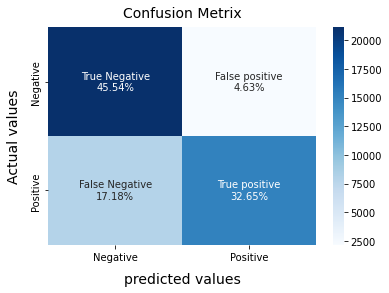

In [ ]:
BN = BernoulliNB(alpha = 2)
BN.fit(X_train, y_train)
Model_Evaluate(BN)

Classification Report               precision    recall  f1-score   support

         0.0       0.94      0.95      0.94     23283
         1.0       0.95      0.94      0.94     23126

    accuracy                           0.94     46409
   macro avg       0.94      0.94      0.94     46409
weighted avg       0.94      0.94      0.94     46409



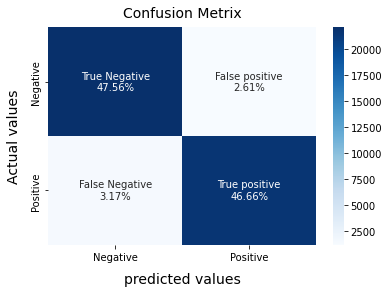

In [ ]:
SVC_Model = LinearSVC()
SVC_Model.fit(X_train, y_train)
Model_Evaluate(SVC_Model)

Classification Report               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95     23283
         1.0       0.95      0.94      0.94     23126

    accuracy                           0.94     46409
   macro avg       0.94      0.94      0.94     46409
weighted avg       0.94      0.94      0.94     46409



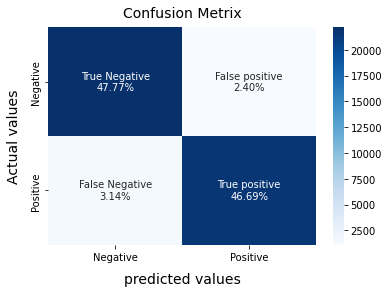

In [ ]:
LG_Model = LogisticRegression(C=2, max_iter= 1000, n_jobs = -1)
LG_Model.fit(X_train, y_train)
Model_Evaluate(LG_Model)

In [ ]:
file = open("vectorizer-ngram-(1, 2).pickle", 'wb')
pickle.dump(vectorizer, file)
file.close

file = open("LogisticRegrassion.pickle", 'wb')
pickle.dump(LG_Model, file)
file.close

file = open("BNB.pickle", 'wb')
pickle.dump(BN, file)
file.close

<function BufferedWriter.close>

In [ ]:
def load_models():
    file = open("vectorizer-ngram-(1, 2).pickle", 'rb')
    vectorizer = pickle.load(file)
    file.close()

    file = open("LogisticRegrassion.pickle", 'rb')
    LR = pickle.load(file)
    file.close()

    return vectorizer, LR

In [ ]:
y_pred_BN = BN.predict(X_test)
BernoulliNB_model = accuracy_score(y_test, y_pred_BN)

y_pred_SVC = SVC_Model.predict(X_test)
SVC_model = accuracy_score(y_test, y_pred_SVC)

y_pred_LR = LG_Model.predict(X_test)
LR_model = accuracy_score(y_test, y_pred_LR)

print("BN accuracy", BernoulliNB_model)
print("SVC accuracy", SVC_model)
print("LR accuracy", LR_model)

BN accuracy 0.7819603956129199
SVC accuracy 0.9421663901398436
LR accuracy 0.9446228102307742


In [ ]:
def predict(vectorizer, model, text):
  text_data = vectorizer.transform(data_preprocess(text))
  sentiment_label = model.predict(text_data)

  output_data = []
  for text, pred in zip(text, intention):
    output_data.append((text, pred))

  df = pd.DataFrame(output_data, columns = ["text", "sentiment"])
  df = df.replace([0, 1], ["Negative", "Positive"])
  
  return df

In [ ]:
test_data = ["My life is going to be end",
               "Death is not good decision",
              "Life is good but suicide gives happiness"]

In [ ]:
predict(vectorizer, LG_Model, test_data)

,text,sentiment
0,My life is going to be end,Positive
1,Death is not good decision,Negative
2,Life is good but suicide gives happiness,Negative


***RNN*** **Part**

In [ ]:
data.head(4)

,tweet,intention
0,Ex Wife Threatening SuicideRecently I left my ...,1.0
1,Am I weird I don't get affected by compliments...,0.0
2,Finally 2020 is almost over... So I can never ...,0.0
3,i need helpjust help me im crying so hard,1.0


In [ ]:
from nltk import word_tokenize
ready_data = data['tweet'].map(word_tokenize).values
total_vocabulary = set(word.lower() for tweet in ready_data for word in tweet)  # set created from nested comprehension 
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique tweets in the dataset.'.format(len(ready_data)))


data.head()

There are 268995 unique words in the dataset.
There are 232045 unique tweets in the dataset.


,tweet,intention
0,Ex Wife Threatening SuicideRecently I left my ...,1.0
1,Am I weird I don't get affected by compliments...,0.0
2,Finally 2020 is almost over... So I can never ...,0.0
3,i need helpjust help me im crying so hard,1.0
4,"Iâm so lostHello, my name is Adam (16) and I...",1.0


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [ ]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
 
demo_model = create_RNN(10, 1, (1,100), activation=['linear', 'linear'])

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

# set the emotion/sentiment as our target
target = data['intention']

# use one hot encoding since our target is categorical
y = pd.get_dummies(target).values

# use keras to create a Tokenizer object
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones
tokenizer.fit_on_texts(list(data['tweet']))
tokenized_texts = tokenizer.texts_to_sequences(data['tweet'])
X = sequence.pad_sequences(tokenized_texts, maxlen=100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processtext,
                                                    intention,
                                                    test_size = 0.2, random_state = 0)

In [ ]:
X_train = vectorizer.transform(X_train)

In [ ]:
X_test = vectorizer.transform(X_test)

In [ ]:
X_test

<46409x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 6476202 stored elements in Compressed Sparse Row format>

In [ ]:
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(100, 1), 
                   activation=['tanh', 'tanh'])

model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=1)

Epoch 1/20
1451/1451 [==============================] - 27s 18ms/step - loss: 0.3889
Epoch 2/20
1451/1451 [==============================] - 28s 19ms/step - loss: 0.2500
Epoch 3/20
1451/1451 [==============================] - 25s 17ms/step - loss: 0.2500
Epoch 4/20
1451/1451 [==============================] - 25s 17ms/step - loss: 0.2500
Epoch 5/20
1451/1451 [==============================] - 24s 16ms/step - loss: 0.2500
Epoch 6/20
1451/1451 [==============================] - 24s 17ms/step - loss: 0.2500
Epoch 7/20
1451/1451 [==============================] - 24s 17ms/step - loss: 0.2500
Epoch 8/20
1451/1451 [==============================] - 25s 17ms/step - loss: 0.2500
Epoch 9/20
1451/1451 [==============================] - 24s 17ms/step - loss: 0.2500
Epoch 10/20
1451/1451 [==============================] - 25s 17ms/step - loss: 0.2500
Epoch 11/20
1451/1451 [==============================] - 24s 16ms/step - loss: 0.2500
Epoch 12/20
1451/1451 [==============================] - 24s 17

In [ ]:
model = create_RNN(hidden_units=50, dense_units=1, input_shape=(100, 1), 
                   activation=['linear', 'linear'])

history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1)

Epoch 1/20
1306/1306 [==============================] - 36s 27ms/step - loss: 56221.8477 - val_loss: 243.8087
Epoch 2/20
1306/1306 [==============================] - 37s 28ms/step - loss: 109.1705 - val_loss: 35.4560
Epoch 3/20
1306/1306 [==============================] - 33s 26ms/step - loss: 16.5219 - val_loss: 6.1098
Epoch 4/20
1306/1306 [==============================] - 34s 26ms/step - loss: 4.1021 - val_loss: 1.7470
Epoch 5/20
1306/1306 [==============================] - 34s 26ms/step - loss: 282.2379 - val_loss: 400.2308
Epoch 6/20
1306/1306 [==============================] - 34s 26ms/step - loss: 313.3711 - val_loss: 10.9477
Epoch 7/20
1306/1306 [==============================] - 33s 26ms/step - loss: 223.7104 - val_loss: 1.1399
Epoch 8/20
1306/1306 [==============================] - 41s 32ms/step - loss: 113.7243 - val_loss: 1.6283
Epoch 9/20
1306/1306 [==============================] - 48s 36ms/step - loss: 209.7374 - val_loss: 0.4521
Epoch 10/20
1306/1306 [==================

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 3)                 15        
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history.history

{'loss': [17102700.0,
  39929.265625,
  223.5937042236328,
  6.420190334320068,
  6.198116779327393,
  5.823054790496826,
  5.166245937347412,
  4.135480880737305,
  2.7031493186950684,
  1.3129725456237793,
  0.4693259596824646,
  0.2632090449333191,
  0.25011396408081055,
  0.25009533762931824,
  1.9927440881729126,
  7.195896625518799,
  9.972973823547363,
  0.2522110044956207,
  7.673486709594727,
  6.965686321258545],
 'val_loss': [214961.34375,
  1466.925048828125,
  6.67923641204834,
  6.289450168609619,
  6.024662971496582,
  5.505338668823242,
  4.671404838562012,
  3.3969671726226807,
  2.0671510696411133,
  0.7208442091941833,
  0.3191239535808563,
  0.2505432665348053,
  0.2500000596046448,
  0.2505964934825897,
  2.274340867996216,
  0.2500004470348358,
  0.25075164437294006,
  0.2688523530960083,
  0.5828548669815063,
  0.25002747774124146]}

In [ ]:
model = Sequential()
embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         34431360  
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 50)                6450      
                                                                 
 dense_12 (Dense)            (None, 2)                 102       
                                                                 
Total params: 34,437,912
Trainable params: 34,437,912
Non-trainable params: 0
_________________________________________

In [ ]:
history.history

{'accuracy': [0.9463285207748413, 0.9499736428260803],
 'loss': [0.14240607619285583, 0.13286320865154266],
 'val_accuracy': [0.9350355267524719, 0.9339581727981567],
 'val_loss': [0.16926047205924988, 0.17728859186172485]}

In [ ]:
len(X_test)

46409

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processtext,
                                                    intention,
                                                    test_size = 0.2, random_state = 0)

# create my NN model
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # use 4 because we have 4 categories

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary() # check the shape

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         34431360  
                                                                 
 lstm (LSTM)                 (None, None, 25)          15400     
                                                                 
 global_max_pooling1d (Globa  (None, 25)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_34 (Dense)            (None, 50)                1300      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                     

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1)

Epoch 1/20
1306/1306 [==============================] - 583s 444ms/step - loss: 0.2532 - accuracy: 0.9047 - val_loss: 0.1929 - val_accuracy: 0.9278
Epoch 2/20
1306/1306 [==============================] - 576s 441ms/step - loss: 0.1781 - accuracy: 0.9372 - val_loss: 0.1818 - val_accuracy: 0.9300
Epoch 3/20
1306/1306 [==============================] - 580s 444ms/step - loss: 0.1579 - accuracy: 0.9439 - val_loss: 0.1856 - val_accuracy: 0.9295
Epoch 4/20
1306/1306 [==============================] - 565s 433ms/step - loss: 0.1389 - accuracy: 0.9501 - val_loss: 0.1923 - val_accuracy: 0.9303
Epoch 5/20
1306/1306 [==============================] - 570s 436ms/step - loss: 0.1268 - accuracy: 0.9549 - val_loss: 0.1994 - val_accuracy: 0.9274
Epoch 6/20
1306/1306 [==============================] - 575s 440ms/step - loss: 0.1167 - accuracy: 0.9586 - val_loss: 0.2034 - val_accuracy: 0.9236
Epoch 7/20
1306/1306 [==============================] - 575s 440ms/step - loss: 0.1063 - accuracy: 0.9626 - val_

[[21473  1642]
 [ 2351 20943]]


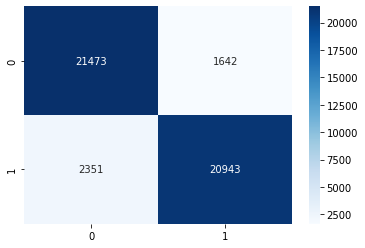

In [ ]:
predict_y = model.predict(X_test)

predict_value = []
y_predict = []
for x in predict_y:
  y_predict.append(x[1]);


test_y = []
for x in y_test:
  test_y.append(x[1]);

for i in y_predict:
     if i>0.5:
       predict_value.append(1)
     else:
      predict_value.append(0);

cnt = 0
predict_val = []
for i in predict_value:
    cnt=cnt+1;
    if cnt> 46409:
      break;
    else:
       predict_val.append(i);

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predict_val)
import seaborn as sns

sns.heatmap(cm , annot=True, cmap="Blues", fmt = "d", cbar = True, annot_kws= {"size": 10})
print(cm)

In [ ]:
true_detection = cm[0][0] + cm[1][1]
accuracy = (true_detection)/ (cm[0][0]+cm[0][1] +cm[1][0]+cm[1][1])
print ("Accuracy")
accuracy

Accuracy


0.9139606541834558

In [ ]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [ ]:
n_unique_words = 10000 # cut texts after this number of words
maxlen = 200
batch_size = 128 

In [ ]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
history=model.fit(X_train, y_train,
           batch_size=batch_size,
           epochs=12,
           validation_data=[X_test, y_test])
print(history.history['loss'])
print(history.history['accuracy'])

Create the word indext

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processtext,
                                                    intention,
                                                    test_size = 0.2, random_state = 0)

In [ ]:
X_train = pad_sequences(X_train, maxlen= max_review_length, padding=pad_type, truncating=trunc_type)

In [ ]:
test_data.head(10)

In [ ]:
documents = [text.split() for text in train_data.tweet]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

In [ ]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()